# ClassificationMetrics

in questo Notebook vogliamo mostrare come è possibile calcolare le varie metriche di classificazione

* accuratezza
* precision
* recall
* confusion matrix
* ROC

Nella prima parte si utilizza soltanto sklearn. nella seconda parte si usa OML con un GLM e si usano i metodi di sklearn per visualizzare la Confusion Matrix e calcolare PREC, RECALL e F1-score

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [54]:
# carico il dataset e creo i Pandas DataFrame
bc = datasets.load_breast_cancer()

bc_data = bc.data.astype(float)

X = pd.DataFrame(bc_data, columns = bc.feature_names)
y = pd.DataFrame(bc.target, columns = ['TARGET'])

In [55]:
# split in train - test (uso i default)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [56]:
# applico un semplice modello di classificazione: Logistic Regression, uso i default
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

logreg = LogisticRegression().fit(X_train_scaled, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_scaled, y_test)))

Training set score: 0.962
Test set score: 0.958


## Su insieme di test: ACC = 0.96

In [57]:
# le predizioni..
pred_test = logreg.predict(X_test_scaled)
pred_test.shape

(143,)

## Calcoliamo la confusion matrix (pag. 166, chap. 6)

Attenzione: nella definizione si usa la convenzione: negativi,positivi e non viceversa

In [58]:
from sklearn.metrics import confusion_matrix

In [59]:
confmat = confusion_matrix(y_true=y_test,y_pred = pred_test)

In [60]:
confmat

array([[51,  4],
       [ 2, 86]])

abbiamo 2 FN e 4 FP

Nota: usando scikit-learn LInearRegression la decision threshold di default è 0.5

### Grafico della Confusion Matrix

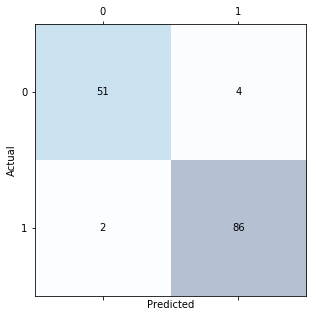

In [61]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Calcolo di PRECISION e RECALL

In [62]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Accuracy: %.3f' % logreg.score(X_test_scaled, y_test))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=pred_test))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=pred_test))
print('F1-score: %.3f' % f1_score(y_true=y_test, y_pred=pred_test))

Accuracy: 0.958
Precision: 0.956
Recall: 0.977
F1-score: 0.966


## Usiamo OML sul dataset Breast Cancer
per poter applicare il calcolo ad OML è sufficiente avere a disposizione i due set: y_test e pred_test

In [63]:
import warnings
warnings.filterwarnings('ignore')

import oml
from oml import automl
from oml import algo
from oml.automl import FeatureSelection

oml.connect("pyquser","pyquser",
            '(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=localhost)(PORT=1521))(CONNECT_DATA=(service_name=OAA1)))',
           automl=True)
oml.isconnected()

True

In [64]:
# salvo il dataset in una tabella del DB
try:
    oml.drop(table='BREASTCANCER')
except:
    pass
BREASTCANCER = oml.create(pd.concat([X, y], axis=1), table = 'BREASTCANCER')
print("Shape:",BREASTCANCER.shape)

Shape: (569, 31)


In [65]:
train_dat, test_dat = oml.sync(table = "BREASTCANCER").split()
test_x, test_y = test_dat.drop('TARGET'), test_dat['TARGET']
train_x = train_dat.drop('TARGET')
train_y = train_dat['TARGET']

In [66]:
from oml.automl import ModelTuning

at = ModelTuning(mining_function = 'classification', parallel=4)

%time results = at.run('glm', train_x, train_y, score_metric='accuracy')

tuned_model = results['best_model']
tuned_model

CPU times: user 196 ms, sys: 117 ms, total: 313 ms
Wall time: 30 s



Algorithm Name: Generalized Linear Model

Mining Function: CLASSIFICATION

Target: TARGET

Settings: 
                    setting name                  setting value
0                 ADMM_CONSENSUS                             .1
1                ADMM_ITERATIONS                             50
2                 ADMM_TOLERANCE                          .0001
3                      ALGO_NAME  ALGO_GENERALIZED_LINEAR_MODEL
4          CLAS_WEIGHTS_BALANCED                            OFF
5                GLMS_CONF_LEVEL                            .95
6            GLMS_FTR_GENERATION    GLMS_FTR_GENERATION_DISABLE
7             GLMS_FTR_SELECTION     GLMS_FTR_SELECTION_DISABLE
8            GLMS_NUM_ITERATIONS                             31
9          GLMS_RIDGE_REGRESSION         GLMS_RIDGE_REG_DISABLE
10                   GLMS_SOLVER         GLMS_SOLVER_LBFGS_ADMM
11      LBFGS_GRADIENT_TOLERANCE                     .000000001
12           LBFGS_HISTORY_DEPTH                             20
1

In [67]:
pred_y = tuned_model.predict(test_x)

In [68]:
test_y_df = test_y.pull()
pred_y_df = pred_y.pull()

In [69]:
print('Accuracy: %.3f' % tuned_model.score(test_x, test_y))
print('Precision: %.3f' % precision_score(y_true=test_y_df, y_pred=pred_y_df))
print('Recall: %.3f' % recall_score(y_true=test_y_df, y_pred=pred_y_df))
print('F1-score: %.3f' % f1_score(y_true=test_y_df, y_pred=pred_y_df))

Accuracy: 0.959
Precision: 0.982
Recall: 0.956
F1-score: 0.969


In [71]:
confmat = confusion_matrix(y_true=test_y_df, y_pred = pred_y_df)

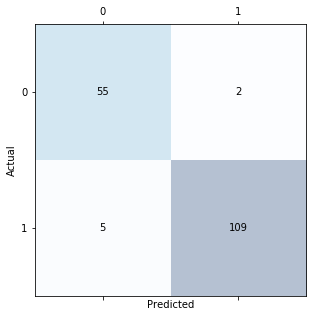

In [72]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Proviamo con SVM_gaussian

In [81]:
# rileggo i dati dal DB (se avessi chiuso la session)
train_dat, test_dat = oml.sync(table = "BREASTCANCER").split()
test_x, test_y = test_dat.drop('TARGET'), test_dat['TARGET']
train_x = train_dat.drop('TARGET')
train_y = train_dat['TARGET']

In [82]:
from oml.automl import ModelTuning

at = ModelTuning(mining_function = 'classification', parallel=4)

%time results = at.run('svm_gaussian', train_x, train_y, score_metric='accuracy')

tuned_model = results['best_model']
tuned_model

CPU times: user 254 ms, sys: 49 ms, total: 303 ms
Wall time: 31.4 s



Algorithm Name: Support Vector Machine

Mining Function: CLASSIFICATION

Target: TARGET

Settings: 
                    setting name                 setting value
0                      ALGO_NAME  ALGO_SUPPORT_VECTOR_MACHINES
1          CLAS_WEIGHTS_BALANCED                           OFF
2                   ODMS_DETAILS                  ODMS_DISABLE
3   ODMS_MISSING_VALUE_TREATMENT       ODMS_MISSING_VALUE_AUTO
4                  ODMS_SAMPLING         ODMS_SAMPLING_DISABLE
5                      PREP_AUTO                            ON
6         SVMS_COMPLEXITY_FACTOR                            10
7            SVMS_CONV_TOLERANCE                         .0001
8           SVMS_KERNEL_FUNCTION                 SVMS_GAUSSIAN
9                SVMS_NUM_PIVOTS                           200
10                  SVMS_STD_DEV                          10.7

Attributes: 
mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmet

In [83]:
pred_y = tuned_model.predict(test_x)

In [84]:
test_y_df = test_y.pull()
pred_y_df = pred_y.pull()

In [85]:
print('Accuracy: %.3f' % tuned_model.score(test_x, test_y))
print('Precision: %.3f' % precision_score(y_true=test_y_df, y_pred=pred_y_df))
print('Recall: %.3f' % recall_score(y_true=test_y_df, y_pred=pred_y_df))
print('F1-score: %.3f' % f1_score(y_true=test_y_df, y_pred=pred_y_df))

Accuracy: 0.988
Precision: 0.991
Recall: 0.991
F1-score: 0.991


In [86]:
confmat = confusion_matrix(y_true=test_y_df, y_pred = pred_y_df)

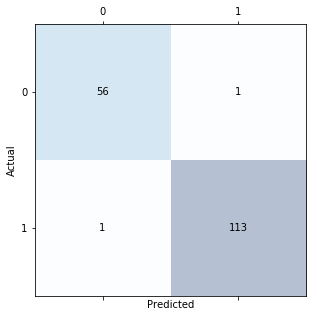

In [87]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()